# synthetic validation


## 1. Real photocurrent, real PSCs

In [90]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt


import subtractr
import subtractr.photocurrent_sim as pcsim
import jax.random as jrand

import circuitmap as cm
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.gridspec import GridSpec
from subtractr import utils
from functools import partial
from jax import vmap

In [78]:
# load photocurrent examples
with h5py.File('../visualization/pc_examples_fastdecay.h5', 'r') as f:
    pc_examples = np.array(f['traces'])
key = jrand.PRNGKey(0)

# load datset with no photocurrents
pscs, stim_mat, powers, targets = utils.load_h5_data('../data/marta/ai203/preprocessed/201118_cell1_A_cmFormat.mat')

# load subtractr net
subtractr_checkpoint = './grid_artifacts/cunning-brattain-9345/cunning-brattain-9345-exp0/scripts/lightning_logs/version_0/checkpoints/epoch=127-step=360063.ckpt'

net = cm.NeuralDemixer(
    path=subtractr_checkpoint,
    unet_args=dict(
            down_filter_sizes=(16, 32, 64, 128),
            up_filter_sizes=(64, 32, 16, 4),
    ))

# load demixer
demixer_checkpoint = '../../circuit_mapping/demixers/nwd_ee_ChroME1.ckpt'
demixer = cm.NeuralDemixer(
    path=demixer_checkpoint,
)

In [133]:
from scipy.stats import multivariate_normal


def make_spatial_opsin_resp(targets, powers, 
    phi_0=0.1, phi_1=35):

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    unique_powers = np.unique(powers)
    unique_tars = np.unique(targets, axis=0)

    num_powers = len(unique_powers)
    num_xs = len(np.unique(unique_tars[:,0]))
    num_ys = len(np.unique(unique_tars[:,1]))
    num_zs = len(np.unique(unique_tars[:,2]))

    opsin_resp_centroid = np.mean(unique_tars, axis=0)
    opsin_resp_cov = np.diag([150, 150, 400])
 
    average_opsin_resp = np.zeros((num_powers, num_xs, num_ys, num_zs))

    rv = multivariate_normal(opsin_resp_centroid, opsin_resp_cov)

    for pidx, power in enumerate(unique_powers):
        power_response = phi_0 * sigmoid(power - phi_1)
        spatial_responses = rv.pdf(unique_tars)
        spatial_power_resp = power_response * spatial_responses
        average_opsin_resp[pidx,...] = np.reshape(spatial_power_resp, (26, 26, 5))

    average_opsin_resp /= np.max(average_opsin_resp)
    return average_opsin_resp

def make_hybrid_dataset(key, psc_tensor, targets,
    templates_path=None, opsin_std_dev=0.1, pc_shape_params=None):

    # if pc_shape_params is None:
    #     pc_shape_params = dict(
    #        O_inf_min=0.3,
    #         O_inf_max=1.0,
    #         R_inf_min=0.3,
    #         R_inf_max=1.0,
    #         tau_o_min=3,
    #         tau_o_max=30,
    #         tau_r_min=3,
    #         tau_r_max=30, 
    #     )

    # calculate average photocurrent amplitude at each
    # (power, x, y, z) combination
    unique_tars = np.unique(targets)
    cell_center = np.mean(unique_tars, axis=0)

    # grab photocurrent shape from templates
    if templates_path is not None:
        with h5py.File(templates_path) as F:
            templates = np.array(F['traces'])

        photocurrent_waveform = np.squeeze(
            subtractr.photocurrent_sim.sample_from_templates(
                templates,
                key,
                size=1,
            )
        )
    else:
        raise NotImplementedError
        # sample a bunch of photocurrent waveforms with the same shape,
        # but with slight jitter
        photocurrent_params = vmap(
            partial(
                pcsim._sample_photocurrent_params,
                **pc_shape_params,
                t_on_min=5.0 + onset_latency_ms, t_on_max=5.0 + onset_latency_ms + onset_jitter_ms,
                t_off_min=10.0 + onset_latency_ms, t_off_max=10.0 + onset_latency_ms + onset_jitter_ms,
            )
        )(keys)

    # create spatial opsin response
    average_opsin_resp = make_spatial_opsin_resp(targets, powers) * 0.8

    # sample from normal modulated by space and power
    opsin_height_samples = np.random.normal(loc=average_opsin_resp[...,None,None],
            size=(*psc_tensor.shape[0:-1], 1), scale=opsin_std_dev)

    # be lazy instead of sampling from truncated normal distribution
    # shouldn't matter too much here
    opsin_height_samples = np.maximum(0, opsin_height_samples)

    num_timesteps = photocurrent_waveform.shape[-1]
    photocurrent_tensor = np.broadcast_to(
        photocurrent_waveform, (*psc_tensor.shape[0:-1], num_timesteps)) \
            * opsin_height_samples

    combined_tensor = psc_tensor + photocurrent_tensor
    return photocurrent_tensor, combined_tensor

def run_subtraction_with_nans(pscs, net):
    valid_idxs = ~np.isnan(pscs.sum(-1))
    pscs_small = pscs[valid_idxs]
    ests = net(pscs_small)
    out = np.zeros_like(pscs)
    out[valid_idxs] = ests
    return out

pscs, stim_mat, powers, targets = utils.load_h5_data('../data/marta/ai203/preprocessed/201119_cell2_A_cmFormat.mat')
pscs = -pscs
psc_tensor = utils.make_psc_tensor_multispot(pscs, powers, targets, stim_mat)



In [134]:

phi_0 = 0.1
phi_1 = 35

key = jrand.PRNGKey(1)
opsin_std_dev = 0.1

# grab photocurrent shape from templates
templates_path = '../visualization/pc_examples_fastdecay.h5'
photocurrent_tensor, combined_tensor = make_hybrid_dataset(
    key, psc_tensor, targets, templates_path
)

combined_tensor = psc_tensor + photocurrent_tensor
combined_obs = np.reshape(combined_tensor, (-1, 900))
ests = run_subtraction_with_nans(combined_obs, net)
subtracted = combined_obs - ests
corrected_tensor = np.reshape(subtracted, combined_tensor.shape)
corrected_map = utils.traces_tensor_to_map(corrected_tensor)
combined_map = utils.traces_tensor_to_map(combined_tensor)
original_map = utils.traces_tensor_to_map(psc_tensor)


/Users/Bantin/anaconda3/envs/circuitmap/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Demixing PSC traces... complete (elapsed time 177.03s, device=cpu).


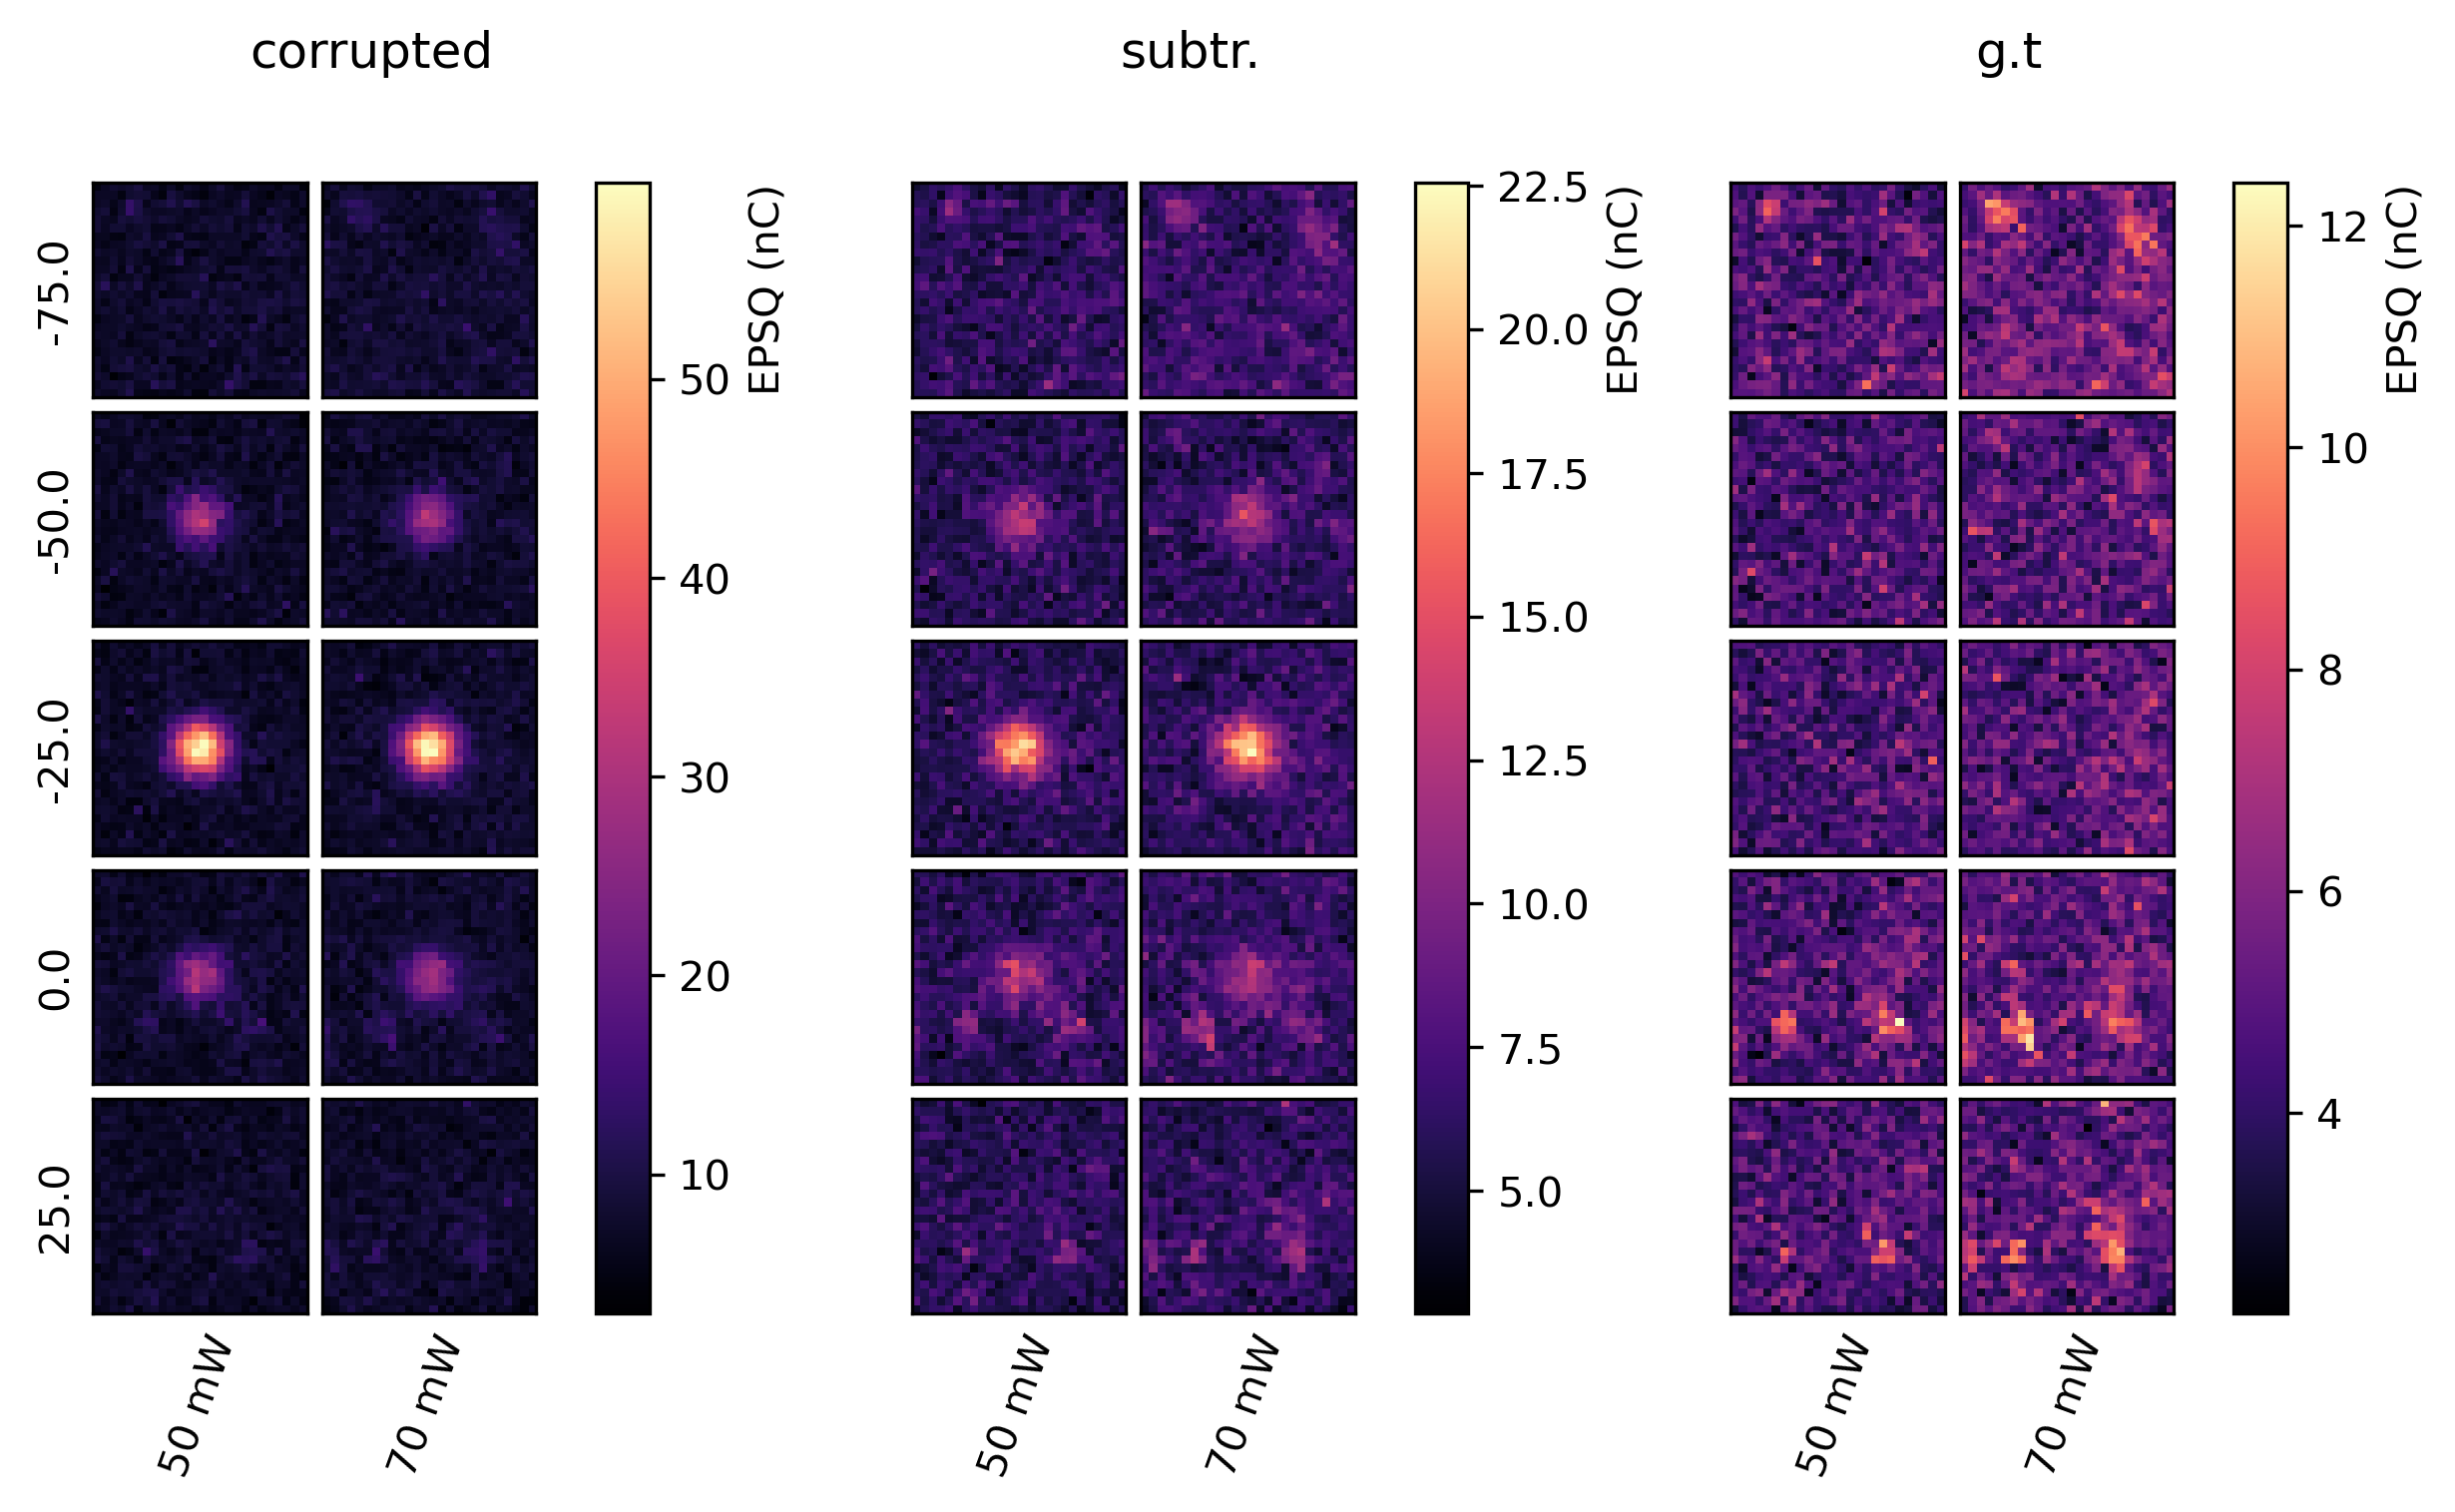

In [136]:

fig1 = plt.figure(figsize=(10, 5), dpi=300, facecolor='white')
utils.plot_multi_means(fig1,
    [combined_map, corrected_map, original_map], 
    np.arange(5),
    cmaps=['magma', 'magma', 'magma', 'magma'],
    cbar_labels=['EPSQ (nC)']*3,
    zlabels=np.unique(targets[:,-1]),
    map_names=['corrupted', 'subtr.', 'g.t'],
    powers=np.unique(powers),
    # vranges=[(0,15), (0,15), (0,15), (0,15)],
    show_powers=(True, True, True, True)
)

In [137]:
mt_net = subtractr.Subtractr.load_from_checkpoint('../subtractr/lightning_logs/version_494457/checkpoints/epoch=219-step=687500.ckpt')
ests = run_subtraction_with_nans(pscs, mt_net)
subtracted = combined_obs - ests
corrected_tensor = np.reshape(subtracted, combined_tensor.shape)

Running photocurrent removal...complete (elapsed time 173.15s, device=cpu).


/var/folders/67/j86q1s2s1_dg5m568j2k9d040000gn/T/ipykernel_1803/4076900628.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


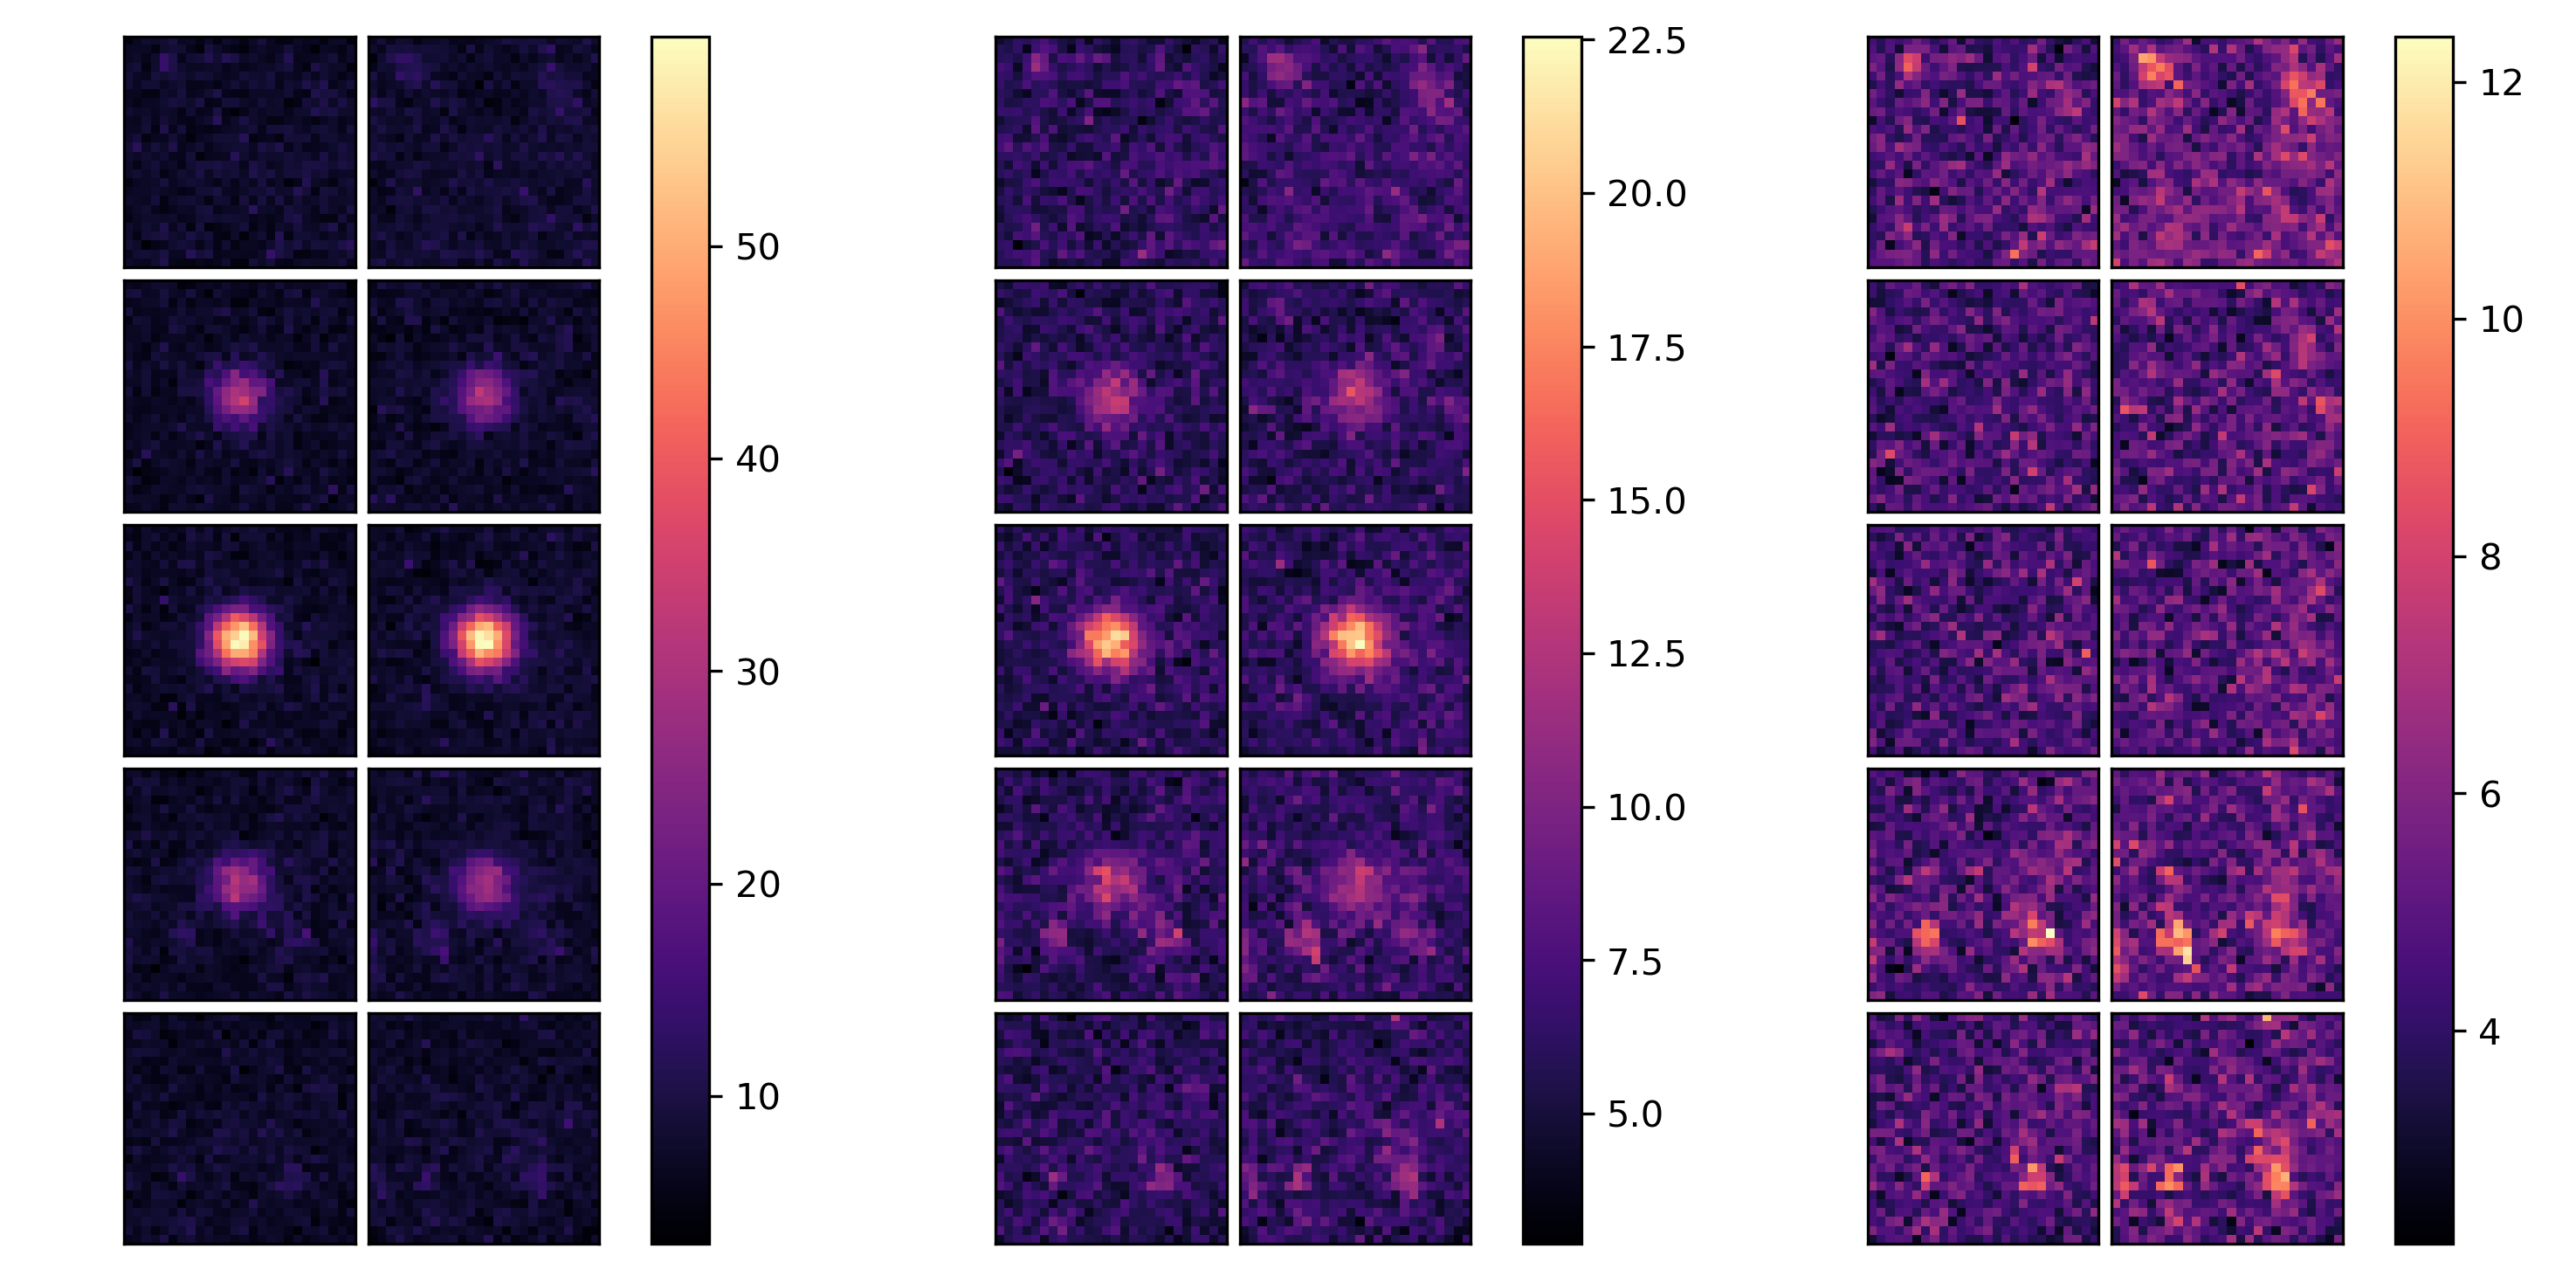

In [138]:
fig1 = plt.figure(figsize=(10, 5), dpi=300, facecolor='white')
utils.plot_multi_means(fig1,
    [combined_map, corrected_map, original_map], 
    np.arange(5),
    cmaps=['magma', 'magma', 'magma', 'magma'],
    # cbar_labels=['EPSQ (nC)'],
    # zlabels=['subtr', 'demix'],
    map_names=['corrupted', 'subtr.', 'g.t'],
    # vranges=[(0,15), (0,15), (0,15), (0,15)],
    show_powers=(True, True, True, True)
)
plt.tight_layout()

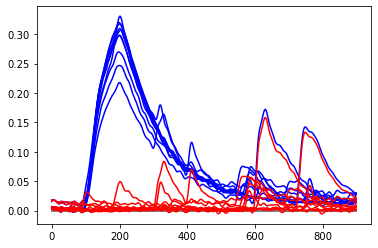

In [142]:
idxs = np.argsort(combined_obs.sum(-1))[::-1]

sorted_obs = combined_obs[idxs]
sorted_ests = ests[idxs]
sorted_pscs = psc_tensor.reshape(-1,900)[idxs]

plt.plot(sorted_obs[0:10].T, color='blue')
plt.plot(sorted_ests[0:10].T, color='grey')
plt.plot(sorted_pscs[0:10].T, color='red')


Demixing PSC traces... complete (elapsed time 0.03s, device=cpu).


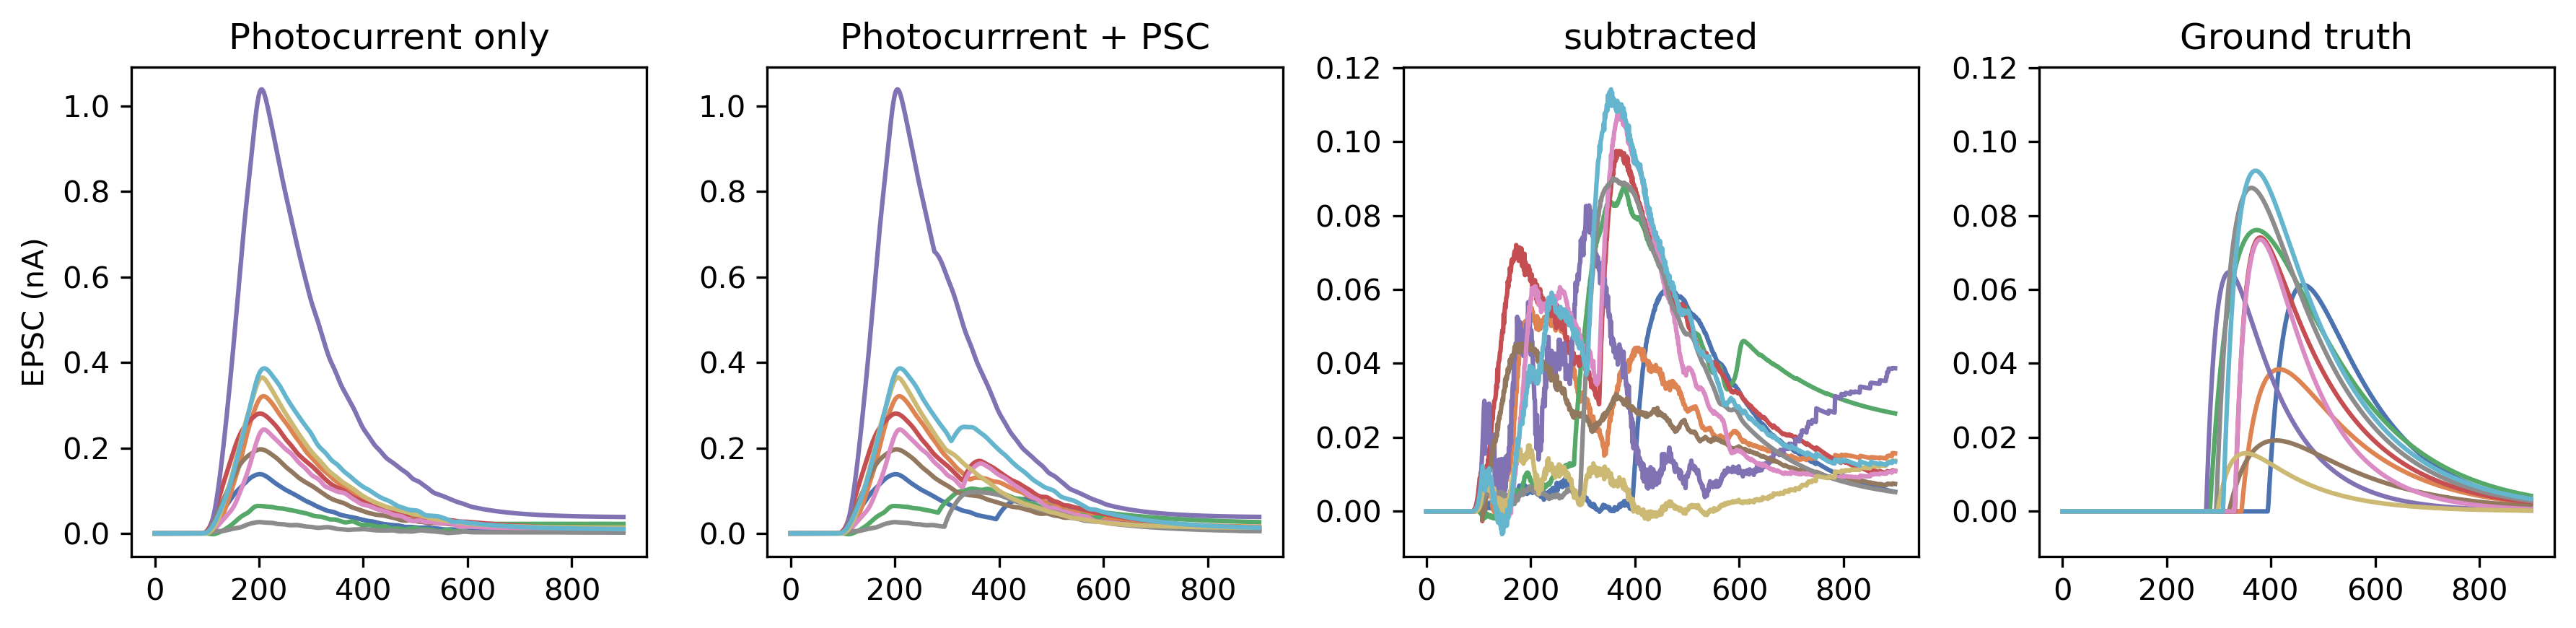

In [9]:
import seaborn as sns
sns.set_palette('deep')

fig,  axs = plt.subplots(1, 4, figsize=(12,3), dpi=300, facecolor='white')

est = net(combined)
subtracted = combined - est

axs[0].plot(photocurrents.T)
axs[1].plot(combined.T)
axs[2].plot(subtracted.T)
axs[3].plot(pscs.T)
axs[3].set_ylim(axs[2].get_ylim())

axs[0].set_title('Photocurrent only')
axs[1].set_title('Photocurrrent + PSC')
axs[2].set_title('subtracted')
axs[3].set_title('Ground truth')
axs[0].set_ylabel('EPSC (nA)')
plt.tight_layout()
plt.show()

## Where during the trial do we tend to make errors?

In [71]:
latencies = np.arange(160, 400, 10)

In [69]:
mses = []
stds = []
for psc_latency in latencies:

    combined, photocurrents, pscs = make_hybrid_dataset(
        pc_examples,
        key,
        size=1000,
        sample_psc_kernel_kwargs=dict(
            delta_lower=psc_latency, delta_upper=psc_latency,
            amplitude_lower=0.01, amplitude_upper=0.2,)
    )

    est = net(combined)
    subtracted = combined - est
    errs = np.square(subtracted - pscs)
    per_trial_err = np.sum(errs, axis=-1)
    mse = np.mean(per_trial_err)
    std = np.std(per_trial_err)

    mses.append(mse)
    stds.append(std)


/Users/Bantin/anaconda3/envs/circuitmap/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Demixing PSC traces... complete (elapsed time 1.79s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.72s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.69s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.71s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.68s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.67s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.77s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.85s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.77s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.75s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.75s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.73s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.72s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.70s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.68s, device=cpu).
Demixing P

<ErrorbarContainer object of 3 artists>

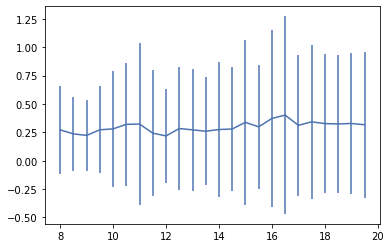

In [72]:
plt.errorbar(latencies * 0.05, mses, stds, None)